In [2]:
import importlib
# --------------------
from sklearn.utils import gen_batches
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
import numpy as np
from numpy.linalg import norm,inv,matrix_rank
import h5py
import datetime
import seaborn as sns
from sklearn.metrics import root_mean_squared_error as RMSE
import matplotlib.pyplot as plt

from pytictoc import TicToc
tim=TicToc()

In [3]:
def gen_slice_month(tim_st,tim_ed):
    tim = datetime.datetime.strptime(tim_st, "%Y%m%d")
    date_ed = datetime.datetime.strptime(  tim_ed, "%Y%m%d")
    ind_st = 0
    batches  = []
    trainset = []
    samples  = []
    count = 0
    while (tim < date_ed ):
        Year = tim.strftime("%Y")
        Month = tim.strftime("%m")
        if Month == '12':
            NextYYMM = "{:04d}01".format(int(tim.strftime("%Y"))+1)
        else:
            NextYYMM = Year+"{:02d}".format(int(tim.strftime("%m"))+1)
        tmp = datetime.datetime.strptime(  NextYYMM+"01" , "%Y%m%d")
        if (tmp > date_ed):
            tmp = date_ed
        days = (tmp - tim ).days
        ind_ed = ind_st + days
        batches.append(slice(ind_st,ind_ed))
        trainset.append(slice(ind_ed))
        samples.append(ind_ed)
        ind_st = ind_ed
        tim += datetime.timedelta(days=days)
    return batches,trainset,samples

In [21]:
def Read_Results(method, case):
    with h5py.File(f"./Results/PLS2_PM25_{method}.h5", "r") as f:
        dat={'timer': f['timer'][:],
             'coef':  f['coef'][:]}
    return dat

def timer_stats(method, timer):
    print(f"{method:s} timer\n"
      + f"  Ave: {np.mean(timer):.4f}\n"
      + f"  Std: {np.std(timer):.4f}")

In [5]:
tim_st = '20200602'
tim_ed = '20221027'
batches, trainset, samples = gen_slice_month(tim_st,tim_ed)
train_ind = trainset[-1]


with h5py.File('./data/TW_PM25.h5', 'r') as f:
    X_train, Y_train = f['X_train'][:], f['Y_train'][:]
    
n_train = X_train.shape[0]


In [6]:
def RunExp(method, PLS, case, save):
    tim = TicToc()
    timlist=np.zeros((2, len(batches)))
    timlist[0] = np.array(samples)
    if (case==1):
        for i,s in enumerate(batches):
            tim.tic()
            PLS.fit(X_train[s], Y_train[s])
            timlist[1,i] = tim.tocvalue()
    else:
        for i,s in enumerate(trainset):
            tim.tic()
            PLS.fit(X_train[s], Y_train[s])
            timlist[1,i] = tim.tocvalue()

    if(method == 'SIMPLS') \
      | (method == 'SVDPLS') \
      | (method == 'ISVDPLS'):
      PLS._comp_coef(PLS.n_components)
    elif (method != 'NIPALS'):
        PLS._comp_coef()


    coef = PLS.coef_

    if (save==1):
        with h5py.File(f"./Results/PLS2_PM25_{method}.h5", "w") as f:
            f_coef = f.create_dataset('coef', data=coef, maxshape=coef.shape, chunks=True)
            f_tim = f.create_dataset('timer', data=timlist, maxshape=timlist.shape, chunks=True)


In [23]:
from sklearn.cross_decomposition import PLSRegression

save=1
tim.tic()
PLS= PLSRegression(n_components=10, scale=False)
RunExp('NIPALS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 6.84951544739306


In [21]:
import Code.OLPLS
importlib.reload(Code.OLPLS)
from Code.OLPLS import OLPLS

save=1
tim.tic()
PLS= OLPLS(n_components=10, mu=1e-8, amnesic=0.99)
RunExp('OLPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 58.43835334619507


In [7]:
import Code.CIPLS
importlib.reload(Code.CIPLS)
from Code.CIPLS import CIPLS

save=1
tim.tic()
PLS= CIPLS(n_components=1)
RunExp('CIPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 0.6426915228366852


In [33]:
import Code.SIMPLS
importlib.reload(Code.SIMPLS)
from Code.SIMPLS import SIMPLS

save=1
tim = TicToc()
tim.tic()
PLS = SIMPLS(n_components=11)
RunExp('SIMPLS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 32.68348323740065


In [34]:
import Code.ISIMPLS
importlib.reload(Code.ISIMPLS)
from Code.ISIMPLS import ISIMPLS2 as ISIMPLS

save=1
tim = TicToc()
tim.tic()
PLS= ISIMPLS(n_components=11)
RunExp('ISIMPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 33.34497662819922


In [39]:
import Code.SVDPLS
importlib.reload(Code.SVDPLS)
from Code.SVDPLS import SVDPLS

save=1
tim.tic()
PLS= SVDPLS(n_components=3, scale=False)
RunExp('SVDPLS', PLS, 0, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 49.42781730182469


In [40]:
import Code.SVDPLS
importlib.reload(Code.SVDPLS)
from Code.SVDPLS import ISVDPLS

save=1
tim.tic()
PLS= ISVDPLS(n_components=3)
RunExp('ISVDPLS', PLS, 1, save)
print("elapsed time:", tim.tocvalue() )

elapsed time: 1.5121026039123535


In [28]:
NIPALS = Read_Results('NIPALS', 0)
OLPLS  = Read_Results('OLPLS', 1)

print("NIPALS v.s. OLPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(NIPALS['coef'], OLPLS['coef'])) )
print("\n")

timer_stats("NIPALS", NIPALS['timer'][1])
timer_stats("OLPLS", OLPLS['timer'][1])

NIPALS v.s. OLPLS
  RMSE of coef.:    3.8254424e-03


NIPALS timer
  Ave: 0.2319
  Std: 0.1150
OLPLS timer
  Ave: 2.0128
  Std: 0.0694


In [ ]:
NIPALS = Read_Results('NIPALS', 0)
CIPLS  = Read_Results('CIPLS', 1)

print("NIPALS v.s. CIPLS")
print("coef Error:  {:15.7e}".format(RMSE(NIPALS['coef'], CIPLS['coef'])) )
timer_stats("CIPLS", CIPLS['timer'][1])

In [29]:
SIMPLS  = Read_Results('SIMPLS', 0)
ISIMPLS = Read_Results('ISIMPLS', 1)

print("SIMPLS v.s. ISIMPLS")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(SIMPLS['coef'], ISIMPLS['coef'])))
print("\n")
timer_stats("SIMPLS", SIMPLS['timer'][1])
timer_stats("ISIMPLS", ISIMPLS['timer'][1])

SIMPLS v.s. ISIMPLS
  RMSE of coef.:    1.4261860e-16


SIMPLS timer
  Ave: 1.1229
  Std: 0.1316
ISIMPLS timer
  Ave: 1.1453
  Std: 0.1226


In [30]:
SVDPLS  = Read_Results('SVDPLS', 0)
ISVDPLS = Read_Results('ISVDPLS', 1)

print("SVDPLS v.s. ISVDPLS ")
print("  RMSE of coef.:  {:15.7e}".format(RMSE(SVDPLS['coef'], ISVDPLS['coef'])))
print("\n")
timer_stats("SVDPLS", SVDPLS['timer'][1])
timer_stats("ISVDPLS", ISVDPLS['timer'][1])

SVDPLS v.s. ISVDPLS 
  RMSE of coef.:    4.7187791e-04


SVDPLS timer
  Ave: 1.7005
  Std: 0.0785
ISVDPLS timer
  Ave: 0.0496
  Std: 0.0619


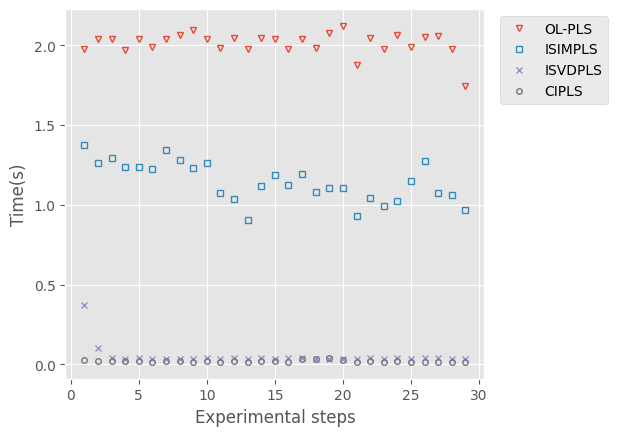

In [45]:
N_steps= len(ISIMPLS['timer'][0])
fig, ax = plt.subplots()
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), OLPLS['timer'][1],
                label='OL-PLS', ls='', marker='v', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), ISIMPLS['timer'][1],
                label='ISIMPLS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), ISVDPLS['timer'][1],
                label='ISVDPLS', ls='', marker='x', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), CIPLS['timer'][1],
                label='CIPLS', ls='', marker='o', markersize=ms, fillstyle='none')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/TW_PM25_inc.pdf')


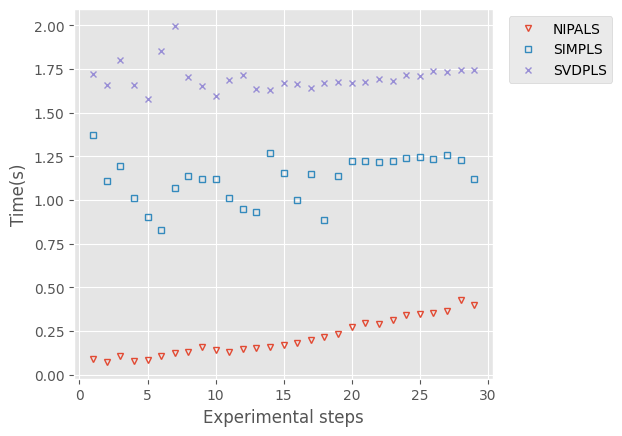

In [44]:
N_steps= len(ISIMPLS['timer'][0])
fig, ax = plt.subplots()
plt.subplots_adjust(right=.65)
plt.style.use('ggplot')
ms = 4

plt.subplots_adjust(right=.78)

plt.plot(range(1,N_steps+1), NIPALS['timer'][1],
         label='NIPALS', ls='', marker='v', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SIMPLS['timer'][1],
         label='SIMPLS', ls='', marker='s', markersize=ms, fillstyle='none')
plt.plot(range(1,N_steps+1), SVDPLS['timer'][1],
         label='SVDPLS', ls='', marker='x', markersize=ms, fillstyle='none')


ax.set_xlabel("Experimental steps")
ax.set_ylabel("Time(s)")
ax.legend(bbox_to_anchor=(1.02,1), loc='upper left')
plt.savefig('./fig/TW_PM25_full.pdf')
# plt.close()